# Replicating TCAV Study

> This notebook aims to replicate the study ["Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV)"](https://arxiv.org/pdf/1711.11279.pdf). 

> We have created a more transparent folder structure, to make it easier for others to replicate the study.  The file "Run_TCAV.ipynb" is the original file modified to the new folder structure, here more specifications about the TCAV packages can be found. If you are interested in obtaining the original file it can be done here --> [TCAV repository](https://github.com/tensorflow/tcav). 


# Table of contents:

### Part A - Tensorflow
1. Preparation for using the TCAV packages

    1.1 TCAV step-by-step


2. The Zebra Example

3. The Zebra Test Example

4. The School Bus Example 

5. The School Bus Test Example 

### Part B - Pytorch

1. Preparation

2. Zebra >< Random

    2.1 Validation against different target images
    

3. Zebra >< Striped, Zigzag and Dotted

    3.1 Validation against different target images
    

4. School Bus >< Man, Woman and Child

    4.1 Validation against different target images 
    

5. Significance testing across layers for different tests
    
    5.1 Zebra: Stripes >< Random
    
    5.2 Zebra: Sripes >< Zigzagged
    
    5.3 School bus: Child >< Random

--------------------------------------------------

# Part A - Tensorflow
## 1. Preparation for using the TCAV packages

> Required Packages:

In [1]:
# %pip install tensorflow
# %pip install tcav

%load_ext autoreload
%autoreload 2

import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

import json

> Set the right folders and path's: 

In [2]:
print ('REMEMBER TO UPDATE YOUR_PATH (where images, models are)!')

# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'  
user = 'andre' #updated
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test4'
working_dir = "/tmp/" + user + '/' + project_name
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
# where the images live.

# TODO: replace 'YOUR_PATH' with path to downloaded models and images. 
# source_dir = "C:/Users/andre/OneDrive/Skrivebord/TCAV_Deep_Learning"
source_dir = "."

utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   


REMEMBER TO UPDATE YOUR_PATH (where images, models are)!


In [3]:
import os
os.getcwd()
#os.chdir(source_dir)

'C:\\Users\\andre\\OneDrive\\Skrivebord\\TCAV_Deep_Learning'

### 1.1 TCAV step-by-step

> The following is taken from the original file

1. **Store example images in each folder**
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **Write a model wrapper** (below uses example from tcav/model.py)
 * an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **Retrieve model activations** (below uses example from tcav/activation_generator.py)
 * an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model
4. Run TCAV and visualize scores for important concepts.

-----------

## 2. The Zebra Example 

> Step 1: Store concept and target class images to local folders

In [4]:
# list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.
bottlenecks = [ 'mixed3a','mixed3b','mixed4a', 'mixed4b', 'mixed4c','mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']
# Possible layer names: 
# layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
#                 'mixed3a', 'mixed3b',
#                 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
#                 'mixed5a', 'mixed5b']

# names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir
target = 'zebra'  
concepts = ["dotted","striped","zigzagged"]  


> Step 2: Write to the pretrained model wrapper

In [5]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = source_dir + "/pretrained_model/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. 
LABEL_PATH = source_dir + "/pretrained_model/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

> Step 3: Implement a class that returns activations 

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations.


In [6]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir+'/concepts', activation_dir, max_examples=100)

> Step 4: Run TCAV and visualize concept importance

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 


In [ ]:
import absl
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

> Export the result to a json file in the 'result folder':

In [ ]:
import json
with open('.\\results\\Zebra_all_layers', 'w+') as json_file:
    json.dump(results, json_file)

> Plot the results:

In [7]:
# Import the results 
# os.listdir(os.getcwd()+"\\results")

f = open('.\\results\\Zebra_all_layers', 'r')
results_zebra= json.load(f)


In [12]:
# Example of how the datastructure is: 
results_zebra[0]

{'cav_key': 'dotted-random500_0-mixed3a-linear-0.1',
 'cav_concept': 'dotted',
 'negative_concept': 'random500_0',
 'target_class': 'zebra',
 'cav_accuracies': {'dotted': 1.0,
  'random500_0': 0.9655172413793104,
  'overall': 0.9827586206896551},
 'i_up': 0.3150684931506849,
 'val_directional_dirs_abs_mean': 0.010211438417947362,
 'val_directional_dirs_mean': 0.009934134419470834,
 'val_directional_dirs_std': 0.049065987689629824,
 'val_directional_dirs': [5.747584695909088e-07,
  0.1913706859171296,
  2.392610864711296e-06,
  1.6629933605436372e-06,
  -0.0017147267035025325,
  -4.345731401603851e-06,
  2.6372985653626365e-07,
  -6.081238711719352e-06,
  -9.044958310634125e-05,
  1.1631219042162411e-06,
  3.4914750155167405e-06,
  1.8415404948711664e-05,
  0.03485774085274227,
  -0.00016666327358803274,
  3.3779356469639495e-05,
  1.3947991862866998e-05,
  0.008831192745194864,
  -0.000588144503410731,
  2.4403492546238346e-06,
  1.8180406279918845e-05,
  5.360770090780556e-08,
  3.238

Class = zebra
  Concept = dotted
    Bottleneck = mixed3a. TCAV Score = 0.36 (+- 0.05), random was 0.51 (+- 0.08). p-val = 0.000 (significant)
    Bottleneck = mixed3b. TCAV Score = 0.36 (+- 0.07), random was 0.49 (+- 0.11). p-val = 0.000 (significant)
    Bottleneck = mixed4a. TCAV Score = 0.28 (+- 0.11), random was 0.49 (+- 0.14). p-val = 0.000 (significant)
    Bottleneck = mixed4b. TCAV Score = 0.21 (+- 0.09), random was 0.50 (+- 0.14). p-val = 0.000 (significant)
    Bottleneck = mixed4c. TCAV Score = 0.50 (+- 0.13), random was 0.52 (+- 0.18). p-val = 0.842 (not significant)
    Bottleneck = mixed4d. TCAV Score = 0.68 (+- 0.22), random was 0.50 (+- 0.25). p-val = 0.029 (significant)
    Bottleneck = mixed4e. TCAV Score = 0.63 (+- 0.22), random was 0.52 (+- 0.27). p-val = 0.203 (not significant)
    Bottleneck = mixed5a. TCAV Score = 0.84 (+- 0.15), random was 0.50 (+- 0.28). p-val = 0.000 (significant)
    Bottleneck = mixed5b. TCAV Score = 0.52 (+- 0.30), random was 0.49 (+- 0.32

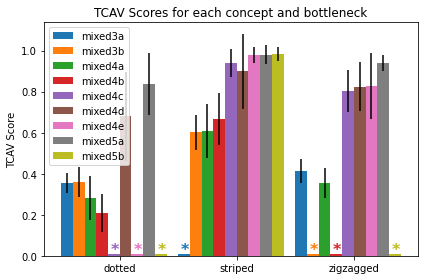

In [13]:
num_random_exp=10
utils_plot.plot_results(results_zebra, num_random_exp=num_random_exp)

------------------

## 3. The Zebra Test Example

> This sections aims to test the methods with other zebra pictures than thoose provided by Imagenet. We have chosen the same amount of pictures, however this time the pictures are from CycleGAN Datasets [link](https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset?resource=download-directory&select=trainB). 

>Step 1: Store concept and target class images to local folders

> **Change project_name to new one.** The previous run will cache results to the harddrive and reuse them here.

In [14]:
# list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.
bottlenecks = [ 'mixed3a','mixed3b','mixed4a', 'mixed4b', 'mixed4c','mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']
# Possible layer names: 
# layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
#                 'mixed3a', 'mixed3b',
#                 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
#                 'mixed5a', 'mixed5b']

# names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir
target = 'zebra'  
concepts = ["dotted","striped","zigzagged"]  

> Step 2: Write to the pretrained model wrapper

In [15]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = source_dir + "/pretrained_model/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. 
LABEL_PATH = source_dir + "/pretrained_model/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

C:\Users\andre\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


> Step 3: Implement a class that returns activations 

In [16]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir+'/concepts/test', activation_dir, max_examples=100)

> Step 4: Run TCAV and visualize concept importance

In [ ]:
import absl
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks, 
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

> Export the result to a json file in the 'result folder':

In [ ]:
import json
with open('.\\results\\Zebra_all_layers_test', 'w+') as json_file:
    json.dump(results, json_file)

> Plot the results:

In [17]:
f = open('.\\results\\Zebra_all_layers_test', 'r')
results_zebra_test= json.load(f)


Class = zebra
  Concept = dotted
    Bottleneck = mixed3a. TCAV Score = 0.52 (+- 0.07), random was 0.50 (+- 0.11). p-val = 0.555 (not significant)
    Bottleneck = mixed3b. TCAV Score = 0.38 (+- 0.10), random was 0.51 (+- 0.12). p-val = 0.002 (significant)
    Bottleneck = mixed4a. TCAV Score = 0.27 (+- 0.10), random was 0.50 (+- 0.17). p-val = 0.000 (significant)
    Bottleneck = mixed4b. TCAV Score = 0.25 (+- 0.12), random was 0.49 (+- 0.16). p-val = 0.000 (significant)
    Bottleneck = mixed4c. TCAV Score = 0.44 (+- 0.14), random was 0.50 (+- 0.19). p-val = 0.328 (not significant)
    Bottleneck = mixed4d. TCAV Score = 0.76 (+- 0.16), random was 0.52 (+- 0.25). p-val = 0.004 (significant)
    Bottleneck = mixed4e. TCAV Score = 0.74 (+- 0.18), random was 0.48 (+- 0.25). p-val = 0.002 (significant)
    Bottleneck = mixed5a. TCAV Score = 0.88 (+- 0.11), random was 0.46 (+- 0.28). p-val = 0.000 (significant)
    Bottleneck = mixed5b. TCAV Score = 0.52 (+- 0.40), random was 0.51 (+- 0.32

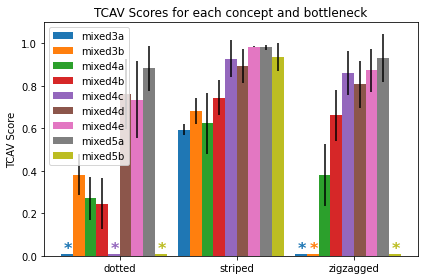

In [18]:
utils_plot.plot_results(results_zebra_test, num_random_exp=num_random_exp)

---------------------------

## 4. The School Bus Example 

>Step 1: Store concept and target class images to local folders

In [19]:
# list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.
bottlenecks = [ 'mixed3a','mixed3b','mixed4a', 'mixed4b', 'mixed4c','mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']
# Possible layer names: 
# layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
#                 'mixed3a', 'mixed3b',
#                 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
#                 'mixed5a', 'mixed5b']

# names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir
target = 'school bus'  
concepts = ["man","woman","child"]  

> Step 2: Write to the pretrained model wrapper

In [20]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = source_dir + "/pretrained_model/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. 
LABEL_PATH = source_dir + "/pretrained_model/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

C:\Users\andre\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


> Step 3: Implement a class that returns activations 

In [21]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir+'/concepts', activation_dir, max_examples=100)

> Step 4: Run TCAV and visualize concept importance

In [ ]:
import absl
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

> Export the result to a json file in the 'result folder':

In [ ]:
import json
with open('.\\results\\Schoolbus_all_layers', 'w+') as json_file:
    json.dump(results, json_file)

> Plot the results:

In [31]:
f = open('.\\results\\Schoolbus_all_layers', 'r')
results_schoolbus= json.load(f)


Class = school bus
  Concept = man
    Bottleneck = mixed3a. TCAV Score = 0.55 (+- 0.10), random was 0.50 (+- 0.19). p-val = 0.388 (not significant)
    Bottleneck = mixed3b. TCAV Score = 0.65 (+- 0.17), random was 0.51 (+- 0.21). p-val = 0.035 (significant)
    Bottleneck = mixed4a. TCAV Score = 0.74 (+- 0.12), random was 0.48 (+- 0.20). p-val = 0.000 (significant)
    Bottleneck = mixed4b. TCAV Score = 0.77 (+- 0.13), random was 0.50 (+- 0.26). p-val = 0.001 (significant)
    Bottleneck = mixed4c. TCAV Score = 0.66 (+- 0.25), random was 0.51 (+- 0.25). p-val = 0.077 (not significant)
    Bottleneck = mixed4d. TCAV Score = 0.69 (+- 0.18), random was 0.52 (+- 0.28). p-val = 0.059 (not significant)
    Bottleneck = mixed4e. TCAV Score = 0.91 (+- 0.08), random was 0.50 (+- 0.29). p-val = 0.000 (significant)
    Bottleneck = mixed5a. TCAV Score = 0.73 (+- 0.17), random was 0.52 (+- 0.31). p-val = 0.038 (significant)
    Bottleneck = mixed5b. TCAV Score = 0.66 (+- 0.32), random was 0.45 (+

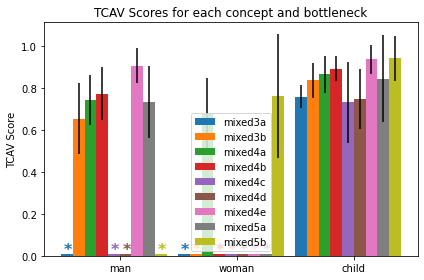

In [32]:
utils_plot.plot_results(results_schoolbus, num_random_exp=num_random_exp)

-----------------------

## 5. The School Bus Test Example 

> This sections aims to test the methods with other school bus pictures than thoose provided by Imagenet. We have chosen the same amount of pictures, however this time the pictures are from images.sv [link](https://images.cv/dataset/school-bus-image-classification-dataset). 

>Step 1: Store concept and target class images to local folders

> **Change project_name to new one.** Same issue as Zebra

In [24]:
# list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.
bottlenecks = [ 'mixed3a','mixed3b','mixed4a', 'mixed4b', 'mixed4c','mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']
# Possible layer names: 
# layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
#                 'mixed3a', 'mixed3b',
#                 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
#                 'mixed5a', 'mixed5b']

# names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir
target = 'school bus'  
concepts = ["man","woman","child"]

> Step 2: Write to the pretrained model wrapper

In [25]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = source_dir + "/pretrained_model/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. 
LABEL_PATH = source_dir + "/pretrained_model/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

C:\Users\andre\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


> Step 3: Implement a class that returns activations 

In [26]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir+'/concepts/test', activation_dir, max_examples=100)

> Step 4: Run TCAV and visualize concept importance

In [ ]:
import absl 
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

> Export the result to a json file in the 'result folder':

In [ ]:
import json
with open('.\\results\\Schoolbus_all_layers_test', 'w+') as json_file:
    json.dump(results, json_file)

> Plot the results:

In [33]:
f = open('.\\results\\Schoolbus_all_layers_test', 'r')
results_schoolbus_test= json.load(f)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
utils_plot.plot_results(results_schoolbus_test, num_random_exp=num_random_exp)

----------------------

# Part B - Pytorch

## Show cases Testing with Concept Activation Vectors (TCAV) on Imagenet Dataset and GoogleNet model

# 1. Preparation

In [1]:
#pip install captum

In [2]:
import numpy as np
import os, glob
import random

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


In [3]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)


In [4]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='./concepts/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors

In [5]:
def assemble_concept(name, id, concepts_path="./concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)


In [6]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))


def plot_tcav_scores(experimental_sets, tcav_scores, filename, transpose = False):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):
        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        if not transpose:

            pos = [np.arange(len(layers))]
            for i in range(1, len(concepts)):
                pos.append([(x + barWidth) for x in pos[i-1]])

            _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
            for i in range(len(concepts)):
                val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
                _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)
                

            # Add xticks on the middle of the group bars
            _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
            _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
            _ax.set_xticklabels(layers, fontsize=16, rotation=25)

            # Create legend & Show graphic
            _ax.legend(fontsize=16)
            plt.savefig("./results/pytorch/" + filename + "_normal")

        else:
            barWidth = 1 / (len(layers) + 1)

            pos = [np.arange(len(concepts))]
            for i in range(1, len(layers)):
                pos.append([(x + barWidth) for x in pos[i-1]])

            _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
            for i in range(len(layers)):
                val = [format_float(tcav_scores[concepts_key][layers[i]]['sign_count'][j]) for j in range(len(concepts))]
                _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=layers[i])

            # Add xticks on the middle of the group bars
            _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
            _ax.set_xticks([r + 2 * barWidth for r in range(len(concepts))])
            _ax.set_xticklabels([concepts[t].name for t in range(len(concepts))], fontsize=16, rotation=25)

            # Create legend & Show graphic
            _ax.legend(fontsize=16)
            plt.savefig("./results/pytorch/" + filename + "_transposed")

    
    
    plt.show()



## Defining GoogleNet Model

For this tutorial, we will load GoogleNet model and set in eval mode.

In [7]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

"view model here: https://netron.app/"

C:\Users\andre\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\andre\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'view model here: https://netron.app/'

In [8]:
layers=['inception4c', 'inception4d', 'inception4e']

layers=['inception3a', 'inception3b','inception4a', 
        'inception4b', 'inception4c', 'inception4d', 
        'inception4e','inception5a', 'inception5b']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))


C:\Users\andre\anaconda3\lib\site-packages\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


# Concept assembly

In [9]:
concepts_path = "./concepts"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)
man_concept = assemble_concept("man", 3, concepts_path=concepts_path)
woman_concept = assemble_concept("woman", 4, concepts_path=concepts_path)
child_concept = assemble_concept("child", 5, concepts_path=concepts_path)


random_0_concept = assemble_concept("random500_0", 6, concepts_path=concepts_path)
random_1_concept = assemble_concept("random500_1", 7, concepts_path=concepts_path)

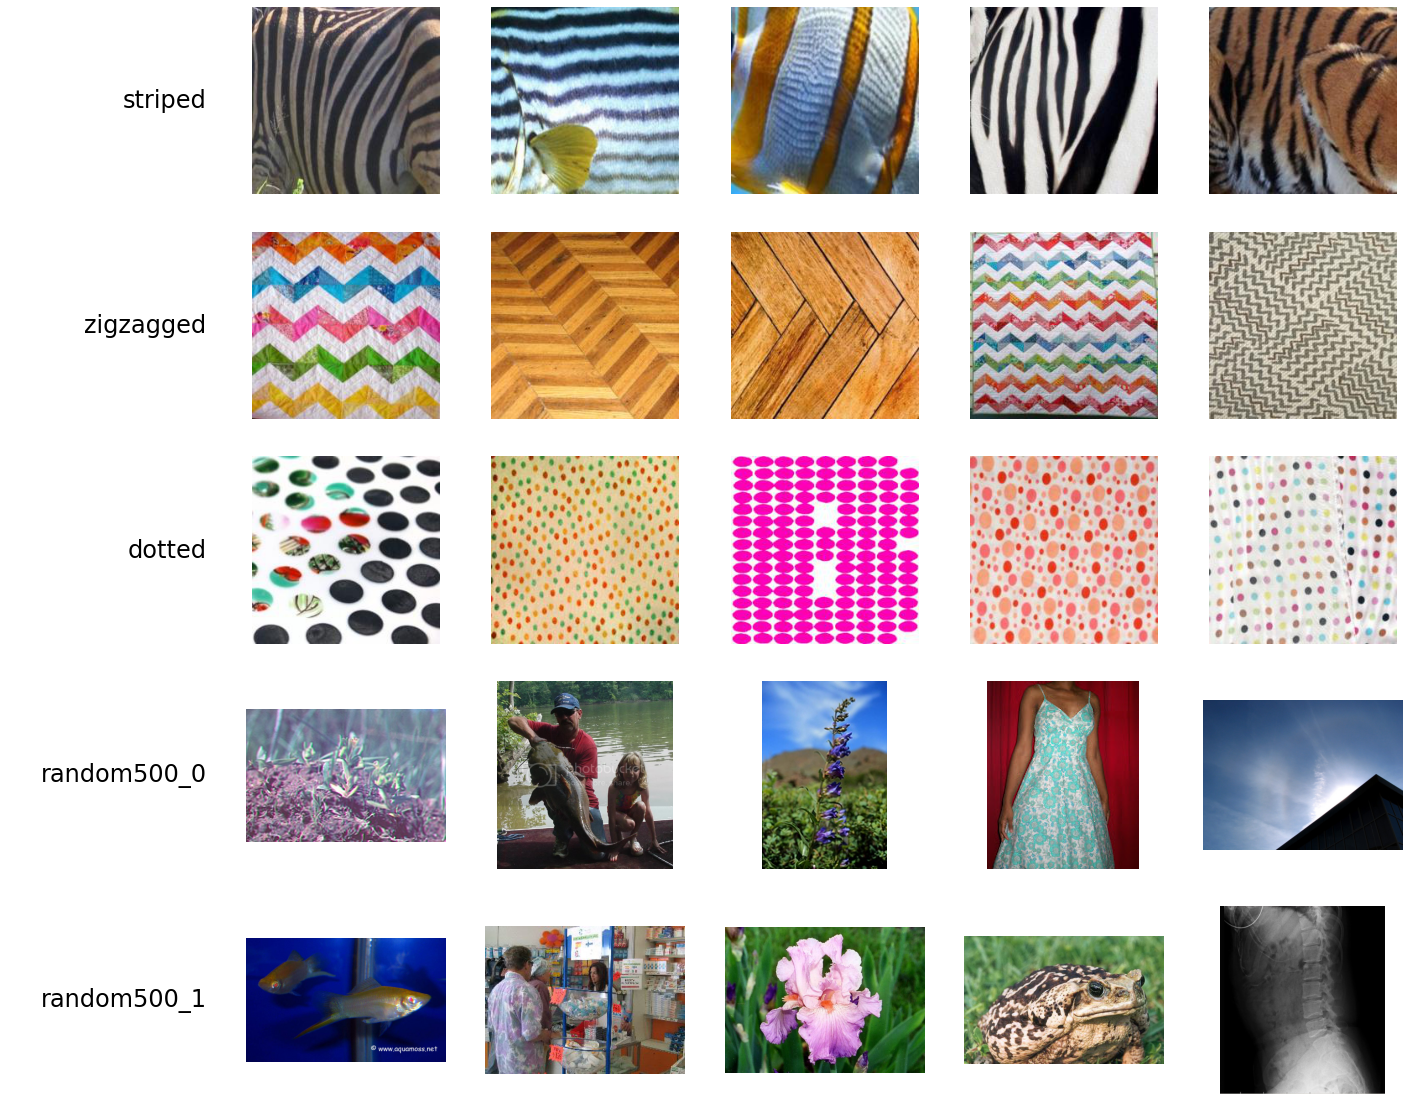

In [10]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [11]:
# Load sample images from folder
zebra_imgs = load_image_tensors('zebra',root_path=concepts_path, transform=False)
zebra_test_imgs = load_image_tensors('zebra',root_path=concepts_path+"/test", transform=False)
school_bus_imgs = load_image_tensors('school bus',root_path=concepts_path, transform=False)
school_bus_test_imgs = load_image_tensors('school bus',root_path=concepts_path+"/test", transform=False)

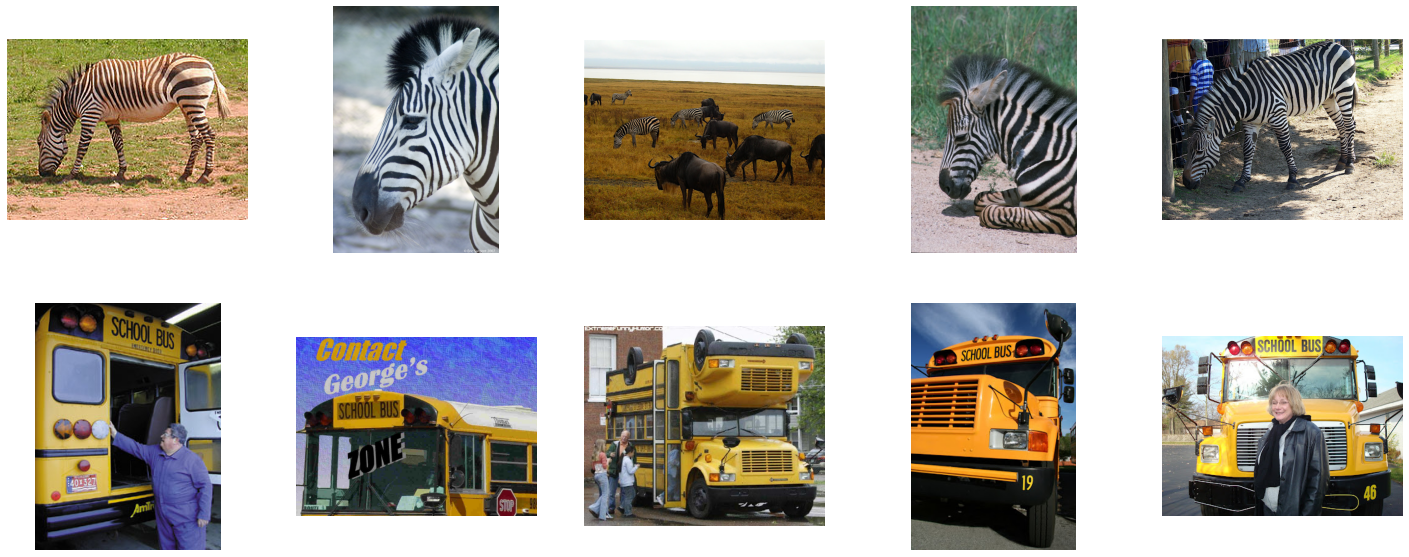

In [12]:
fig, axs = plt.subplots(2, 5, figsize = (25, 10))
for i in range(5):
    axs[0,i].imshow(zebra_imgs[random.randint(0,len(zebra_imgs))])
    axs[0,i].axis('off')
    axs[1,i].imshow(school_bus_imgs[random.randint(0,len(school_bus_imgs))])
    axs[1,i].axis('off')

plt.show()

In [13]:
# Load sample images from folder
zebra_tensors = torch.stack([transform(img) for img in zebra_imgs])
zebra_test_tensors = torch.stack([transform(img) for img in zebra_test_imgs])
school_bus_tensors = torch.stack([transform(img) for img in school_bus_imgs])
school_bus_test_tensors = torch.stack([transform(img) for img in school_bus_test_imgs])

zebra_ind = 340
school_bus_ind = 779

# indices found at: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

# 2. Zebra experiment >< Random

In [ ]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]

tcav_scores_w_random = mytcav.interpret(inputs=zebra_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random

In [ ]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random, "Zebra_striped_random", transpose=True)

In [ ]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random,"Zebra_striped_random", transpose=False)

## 2.1 Zebra test >< Random

In [ ]:
tcav_scores_w_random_test = mytcav.interpret(inputs=zebra_test_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
                                        n_steps=5,
                                       )

In [ ]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random_test, "Zebra_test_striped_random", transpose=True)

In [ ]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random_test,"Zebra_test_striped_random", transpose=False)

# 3. Zebra experiment >< Custom concepts

In [ ]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]


tcav_scores_w_zig_dot = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=zebra_ind,
                                         n_steps=5)

In [ ]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot, "Zebra_striped_dot_zig", transpose=True)

In [ ]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot, "Zebra_striped_dot_zig", transpose=False)

## 3.1 Zebra test >< Custom concepts

In [ ]:
tcav_scores_w_zig_dot_test = mytcav.interpret(inputs=zebra_test_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=zebra_ind,
                                         n_steps=5)


In [ ]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot_test, "Zebra_test_striped_dot_zig", transpose=True)

In [ ]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot_test, "Zebra_test_striped_dot_zig", transpose=False)

# 4. School bus experiment >< custom concepts

In [ ]:
experimental_set_school_bus = [[man_concept, woman_concept, child_concept]]


tcav_scores_w_school_bus = mytcav.interpret(inputs=school_bus_tensors,
                                         experimental_sets=experimental_set_school_bus,
                                         target=school_bus_ind,
                                         n_steps=5)



In [ ]:
tcav_scores_w_school_bus

In [ ]:
plot_tcav_scores(experimental_set_school_bus, tcav_scores_w_school_bus,"School_bus", transpose=True)

In [ ]:
plot_tcav_scores(experimental_set_school_bus, tcav_scores_w_school_bus,"School_bus", transpose=False)

## 4.1 School bus test >< custom concepts

In [ ]:
tcav_scores_w_school_bus_test = mytcav.interpret(inputs=school_bus_test_tensors,
                                         experimental_sets=experimental_set_school_bus,
                                         target=school_bus_ind,
                                         n_steps=5)

In [ ]:
plot_tcav_scores(experimental_set_school_bus, tcav_scores_w_school_bus_test,"School_bus_test", transpose=True)

In [ ]:
plot_tcav_scores(experimental_set_school_bus, tcav_scores_w_school_bus_test,"School_bus_test", transpose=False)

# 5. Significant testing

## 5.1 Stripes >< Random

In [ ]:
n = 2

random_concepts = [assemble_concept('random500_' + str(i+2), i+10) for i in range(0, n)]

experimental_sets = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]
experimental_sets.extend([[stripes_concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([random_0_concept, random_1_concept])
experimental_sets.extend([[random_0_concept, random_concept] for random_concept in random_concepts])

experimental_sets

In [ ]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])
        
    return score_list

In [ ]:
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):
    
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)
    
    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")
        
    return P1, P2, format_float(pval), relation


In [ ]:
# Run TCAV
scores = mytcav.interpret(zebra_tensors, experimental_sets, zebra_ind, n_steps=5)

In [ ]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)
        
    plt.savefig("./results/pytorch/" + "Boxplot_Stripes_Random_"+layer)
    plt.show()

In [ ]:
show_boxplots ("inception4c")

In [ ]:
for l in layers:
    show_boxplots (l)

## 5.2 Testing Stripes >< Zigzag

In [ ]:
experimental_sets = [[stripes_concept, zigzagged_concept], [stripes_concept, random_1_concept]]
experimental_sets.extend([[stripes_concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([zigzagged_concept, random_1_concept])
experimental_sets.extend([[zigzagged_concept, random_concept] for random_concept in random_concepts])

experimental_sets

In [ ]:
# Run TCAV
scores = mytcav.interpret(zebra_tensors, experimental_sets, zebra_ind, n_steps=5)

In [ ]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)
    
    plt.savefig("./results/pytorch/" +"Boxplot_Stripes_Zigzag_"+layer)
    plt.show()

In [ ]:
show_boxplots ("inception4c")

In [ ]:
for l in layers:
    show_boxplots (l)

## 5.3 School Bus: Child >< Random

In [ ]:
experimental_sets = [[child_concept, random_0_concept], [child_concept, random_1_concept]]
experimental_sets.extend([[child_concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([random_0_concept, random_1_concept])
experimental_sets.extend([[random_0_concept, random_concept] for random_concept in random_concepts])

experimental_sets

In [ ]:
# Run TCAV
scores = mytcav.interpret(school_bus_tensors, experimental_sets, school_bus_ind, n_steps=5)

In [ ]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)
    
    plt.savefig("./results/pytorch/" + "Boxplot_child_random_"+layer)
    plt.show()

In [ ]:
show_boxplots ("inception5a")

In [ ]:
for l in layers:
    show_boxplots (l)